## Введение в машинное обучение

### Домашнее задание №4

Задание выполнил(а): Лунева Полина

Задание включает работу с двумя пакетами для для обучения градиентного бустинга, а также алгоритмы кластеризации и TSNE

## Часть 1: градиентный бустинг

В этой части мы будем прогнозировать задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.

In [56]:
import pandas as pd
import numpy as np

df = pd.read_csv('flight_delays_train.csv')
print(df.shape)
df.head()

(100000, 9)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Давайте возьмём только целочисленные переменные `Distance` и `DepTime`.

In [3]:
from sklearn.model_selection import train_test_split

X = df[['Distance', 'DepTime']].values
y = df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

Обучим два бустинга из двух самых популярных библиотек: `xgboost` и `catboost`.

In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])

0.7053519530341781

In [6]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [7]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier()
model_cat.fit(X_train, y_train, verbose=False)
roc_auc_score(y_test, model_cat.predict_proba(X_test)[:, 1])

0.7085086628524928

Из коробки catboost отрабоатал лучше, чем XGBoost. И это мы ещё не использовали его главное приемущество, работу с категориальными фичами из коробки.

__[2 балла]__ посмотрите на категориальные переменные из датасета. Насколько они разнообразны? Есть ли в них редкие категории? Сделайте предобработку всех категориаьных переменных и обучите XGBoost. Измерьте его качество на тестовой выборке. 

In [8]:
# Проверка наличия пропусков:
df.isnull().any().any()

# Пропусков нет

False

In [33]:
# Только категориальные переменные:
object_columns = df.columns[df.dtypes == 'object']

In [55]:
# Разнообразие категориальных переменных
# Количество уникальных значений для каждой переменной:
data_frame = pd.DataFrame(columns=['Категориальный признак', 'Количество уникальных значений'])
for column in object_columns:
    row = {'Категориальный признак': column, 'Количество уникальных значений': len(df[column].unique())}
    data_frame = data_frame.append(row, ignore_index=True)
data_frame

,Категориальный признак,Количество уникальных значений
0,Month,12
1,DayofMonth,31
2,DayOfWeek,7
3,UniqueCarrier,22
4,Origin,289
5,Dest,289
6,dep_delayed_15min,2


In [10]:
# Распределение значений для каждой категориальной переменной по количеству:
for column in object_columns:
    print(f'Распределение значений {column}:', df[column].value_counts(), '', sep='\n')

Распределение значений Month:
c-8     8830
c-7     8706
c-3     8595
c-5     8543
c-6     8414
c-4     8408
c-10    8405
c-12    8265
c-11    8178
c-9     8163
c-1     8075
c-2     7418
Name: Month, dtype: int64

Распределение значений DayofMonth:
c-1     3399
c-20    3380
c-6     3377
c-22    3374
c-14    3366
c-17    3347
c-10    3342
c-27    3330
c-28    3321
c-5     3321
c-23    3314
c-25    3314
c-21    3312
c-19    3305
c-15    3297
c-2     3285
c-9     3283
c-7     3272
c-8     3258
c-4     3249
c-18    3246
c-26    3241
c-16    3240
c-13    3238
c-3     3228
c-12    3212
c-24    3210
c-11    3168
c-30    2976
c-29    2837
c-31    1958
Name: DayofMonth, dtype: int64

Распределение значений DayOfWeek:
c-4    14736
c-5    14657
c-2    14604
c-1    14569
c-3    14508
c-7    14097
c-6    12829
Name: DayOfWeek, dtype: int64

Распределение значений UniqueCarrier:
WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO 

In [100]:
# Редкие категории
# Распределение значений по долям, меньшим 0.1%, и общая доля (сумма долей, меньших 0.1%) для каждой переменной:
for column in object_columns:
    if any(df[column].value_counts(normalize=True) < 0.001) == True:
        print(f'Распределение долей значений {column}, которые меньше 0.1%:', df[column].value_counts(normalize=True)[df[column].value_counts(normalize=True) < 0.001], '',
              f'Общая доля таких значений для {column}:', df[column].value_counts(normalize=True)[df[column].value_counts(normalize=True) < 0.001].sum(), '', sep='\n')

Распределение долей значений Origin, которые меньше 0.1%:
MYR    0.00097
FNT    0.00093
GPT    0.00092
FSD    0.00088
SBP    0.00088
        ...   
VIS    0.00001
WYS    0.00001
ILG    0.00001
VCT    0.00001
ADK    0.00001
Name: Origin, Length: 170, dtype: float64

Общая доля таких значений для Origin:
0.056639999999999996

Распределение долей значений Dest, которые меньше 0.1%:
VPS    0.00099
MAF    0.00099
MYR    0.00097
HRL    0.00094
PWM    0.00093
        ...   
LWB    0.00001
TEX    0.00001
ACK    0.00001
TTN    0.00001
VCT    0.00001
Name: Dest, Length: 172, dtype: float64

Общая доля таких значений для Dest:
0.059199999999999996



In [57]:
df_xgboost = df.copy()

In [102]:
df_xgboost['dep_delayed_15min'] = df_xgboost['dep_delayed_15min'].replace(['N', 'Y'], [0, 1])

In [92]:
# Замена значений, которые встречаются менее 100 раз на "Другое":
for column in object_columns:
    if any(df[column].value_counts() < 100) == True:
        for element in df[column].value_counts()[df[column].value_counts() < 100].index.to_list():
            df_xgboost[column] = df_xgboost[column].replace(element, 'Другое')
        print(column)

Origin
Dest


In [101]:
# Функция для обработки категориальных признаков с помощью mean target:
def mean_target_encoding(df, target, column):
    mean_encoding = df.groupby(column)[target].mean()
    df[column] = df[column].map(mean_encoding)
    return (df)

In [103]:
mte_columns = ['Month', 'DayofMonth', 'DayOfWeek']
target = 'dep_delayed_15min'
for column in mte_columns:
    mean_target_encoding(df_xgboost, target, column)

In [104]:
# One-hot encoding:
df_xgboost = pd.get_dummies(df_xgboost, columns=['UniqueCarrier', 'Origin', 'Dest'])

In [106]:
X_xgb = df_xgboost.drop('dep_delayed_15min', axis=1)
y_xgb = df_xgboost['dep_delayed_15min']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.1, stratify=y_xgb)

In [107]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_xgb, y_train_xgb)
roc_auc_score(y_test_xgb, model_xgb.predict_proba(X_test_xgb)[:, 1])

0.7507710455105956

__[2 балла]__ для Catboost предобработку категориальных переменных делать не надо. Их достаточно перечислить в опции `cat_features`. Попробуйте обучить модель с их учётом, измерьте её качество на тестовой выборке.

In [116]:
X_cat = df.drop(['dep_delayed_15min'], axis=1)
y_cat = df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.1, stratify=y_cat)

object_columns_cat = X_cat.columns[X_cat.dtypes == 'object']

model_cat = CatBoostClassifier(cat_features=object_columns_cat.to_list())
model_cat.fit(X_train_cat, y_train_cat, verbose=False)
roc_auc_score(y_test_cat, model_cat.predict_proba(X_test_cat)[:, 1])

0.7775077484056865

__[2 балла]__ Попробуем выжать максимум из наших бустингов. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74. Для подбора гиперпараметров используйте валидационную выборку либо кросс-валидацию. На тестовой выборке должен быть сделан только финальный замер результата. 

__Что можно попробовать для catboost:__

- Включите опцию `plot=True`, чтобы отрисовывалась красивая картинка с метриками
- Используйте `eval_set`, `use_best_model` и `early_stopping_rounds` чтобы вовремя на валидационной выборке детектировать переобучение модели и останавливаться
- Попробуйте перебрать разные скорости обучения `learning_rate`, регуляризацию `l2_leaf_reg` и глубину деревьев `max_depth`
- Попробуйте перебрать любые другие параметры, за вдохновением можно обратиться [к туториалам из документации.](https://github.com/catboost/tutorials) Например, вот тут код с разными способами перебора [от GreedSearch до оптуны.](https://github.com/catboost/tutorials/tree/master/hyperparameters_tuning) Вам достаточно сделать базовый GreedSearch.
 

__Что можно попробовать для XGboost:__

- Попробуйте перебирать скорости обучения `learning_rate`, `max_depth`, `min_child_weight`, `gamma`, `colsample_bytree`. За что отвечают эти параметры [прочтите в документации](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters)


In [ ]:
# Порог roc_auc_score 0.74 преодолен как для catboost, так и для XGboost (в двух предыдущих пунктах)

## Часть 2: кластеризация

__[2 балла]__ Возьмите колонки `Distance` и `DepTime`. Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

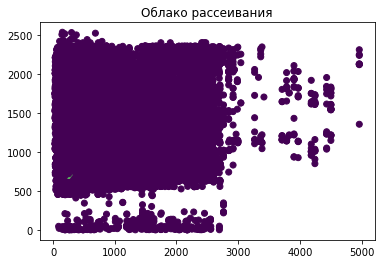

In [150]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

X_clust = df[['Distance', 'DepTime']].values
y_clust = df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train_clust, X_test_clus, y_train_clust, y_test_clust = train_test_split(X_clust, y_clust, test_size=0.1, stratify=y_clust)

dbscan = DBSCAN(eps=0.3, min_samples=7) # по умолчанию eps=0.5, min_samples=5
clusters = dbscan.fit_predict(X_train_clust)

plt.title('Облако рассеивания')
plt.scatter(X_train_clust[:, 0], X_train_clust[:, 1], c=clusters)
plt.show()

In [125]:
# Количество уникальных значений кластеров:
len(np.unique(clusters))

16

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

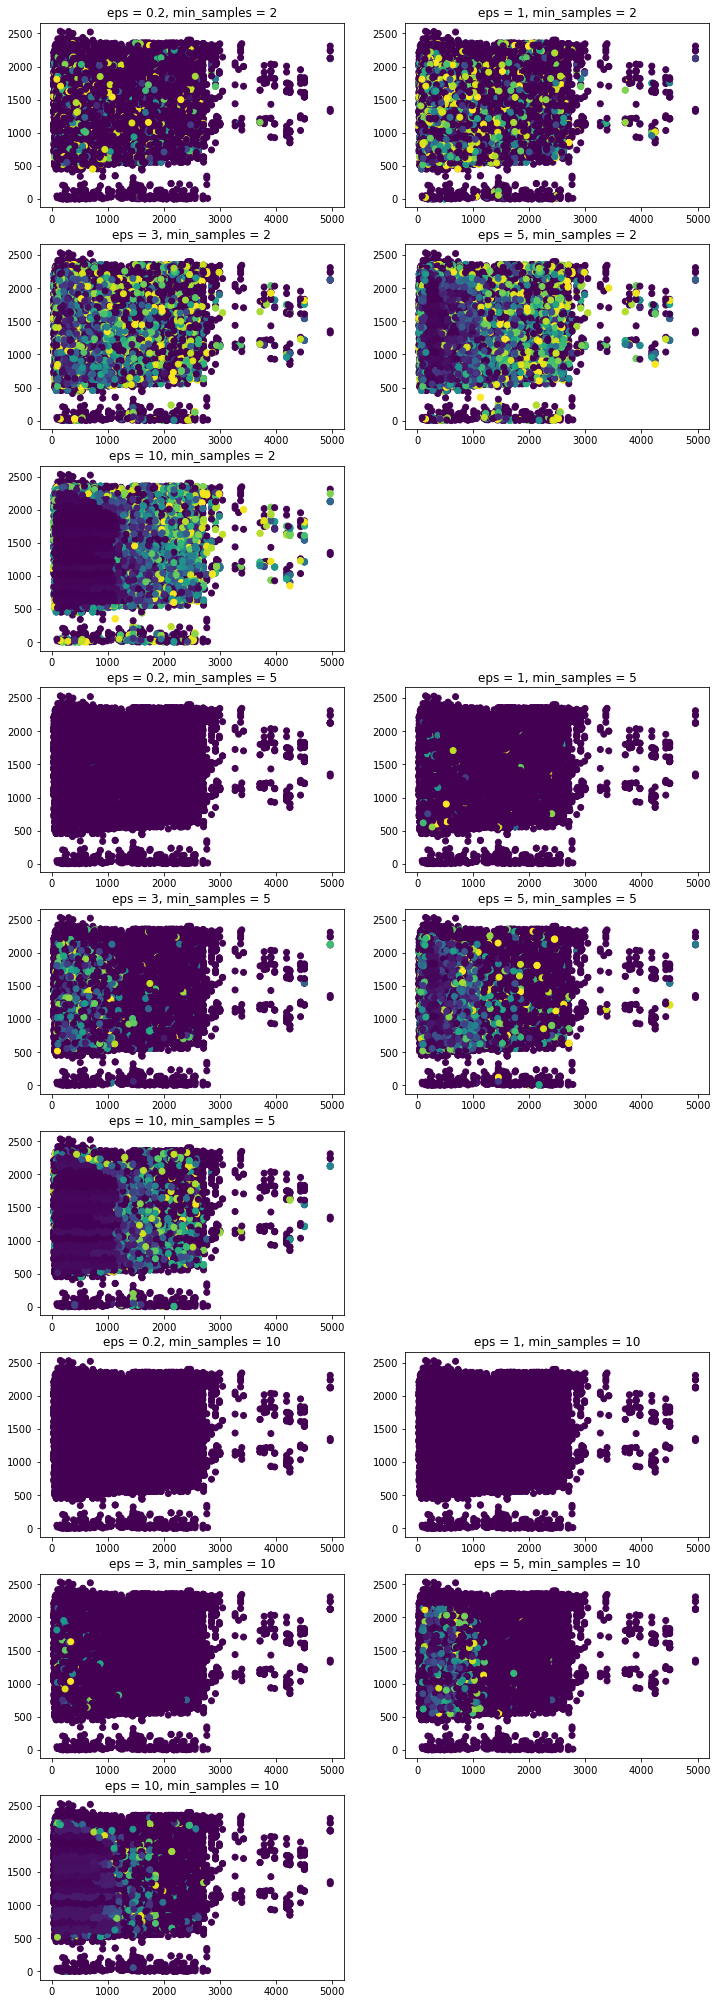

In [149]:
plt.figure(figsize=(12, 36))
i = 1
for sample in [2, 5, 10]:
  for e in [0.2, 1, 3, 5, 10]:
    dbscan = DBSCAN(eps=e, min_samples=sample)
    clusters = dbscan.fit_predict(X_train_clust)
    plt.subplot(9, 2, i)
    plt.scatter(X_train_clust[:, 0], X_train_clust[:, 1], c=clusters)
    plt.title('eps = {}, min_samples = {}'.format(e, sample))
    i += 1
  i += 1
plt.show()

# Больше всего шумовых точек при выборе маленьких значениях параметра eps (так как максимальное расстояние между объектами,
# принадлежащими одному кластеру, слишком маленькое, из-за чего не все объекты, которые должны принадлежать одному кластеру,
# попадают в него), а большие значения параметра min_samples требуют большого количества объектов, принадлежащих одному кластеру;
# наоборот, больших значениях параметров eps и min_samples (так как максимальное расстояние между объектами,
# принадлежащими одному кластеру, и минимальное количество объектов, принадлежащих одному кластеру, слишком большие,
# из-за чего модель считает все объекты за один кластер.

__[2 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [154]:
df_dbscan = df.copy()

eps, min_samples = 4, 2
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_clust)
df_dbscan['Cluster'] = clusters

In [155]:
X_dbscan = df_dbscan.drop(['dep_delayed_15min'], axis=1)
y_dbscan = df_dbscan['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train_dbscan, X_test_dbscan, y_train_dbscan, y_test_dbscan = train_test_split(X_dbscan, y_dbscan, test_size=0.1, stratify=y_dbscan)

In [156]:
object_columns_dbscan = X_dbscan.columns[X_dbscan.dtypes == 'object']

model_cat = CatBoostClassifier(cat_features=object_columns_dbscan.to_list())
model_cat.fit(X_train_dbscan, y_train_dbscan, verbose=False)
roc_auc_score(y_test_dbscan, model_cat.predict_proba(X_test_dbscan)[:, 1])

# Качество модели улучшилось, так как категориальный признак с номером кластера помогает модели сделать предсказание (дополнительная информация об объекте)

0.7855962821146246

In [165]:
# ДОПОЛНИТЕЛЬНО
from sklearn.model_selection import GridSearchCV
cat = GridSearchCV(CatBoostClassifier(cat_features=object_columns_dbscan.to_list()), 
                   param_grid={'iterations' : range(1, 5, 1), 'depth' : range(1, 20, 2)}, scoring='roc_auc')
cat.fit(X_train_dbscan, y_train_dbscan)
cat.predict(X_test_dbscan)
parameters_cat_best = cat.best_params_

Learning rate set to 0.5
0:	learn: 0.5389066	total: 12.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5386429	total: 16.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5385922	total: 13.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5385195	total: 13.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5388363	total: 14ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5389066	total: 13.2ms	remaining: 13.2ms
1:	learn: 0.4900758	total: 24.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5386429	total: 12.9ms	remaining: 12.9ms
1:	learn: 0.4893309	total: 23.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5385922	total: 36.6ms	remaining: 36.6ms
1:	learn: 0.4889123	total: 47.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5385195	total: 15.3ms	remaining: 15.3ms
1:	learn: 0.4887800	total: 36.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5388363	total: 13.5ms	remaining: 13.5ms
1:	learn: 0.4894512	total: 24.2ms	remaining: 0us
Le

C:\Users\harri\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\harri\anaconda3\lib\site-packages\catboost\core.py", line 5007, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\harri\anaconda3\lib\site-packages\catboost\core.py", line 2262, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\harri\anaconda3\lib\site-packages\catboost\core.py", line 2194, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6032, in _catboost._check_train_params
  File "

Learning rate set to 0.5
0:	learn: 0.5324598	total: 728ms	remaining: 2.18s
1:	learn: 0.4826933	total: 757ms	remaining: 757ms
2:	learn: 0.4581590	total: 1.14s	remaining: 380ms
3:	learn: 0.4486242	total: 1.26s	remaining: 0us


In [166]:
model_cat = CatBoostClassifier(cat_features=object_columns_dbscan.to_list(), iterations=parameters_cat_best['iterations'],
                               depth=parameters_cat_best['depth'])
model_cat.fit(X_train_dbscan, y_train_dbscan, verbose=False)
roc_auc_score(y_test_dbscan, model_cat.predict_proba(X_test_dbscan)[:, 1])

0.7151877703897764

__Ответ:__